# QRT: Stock Return Prediction (Chen Zhou)

This notebook illustrates how I understand this project and how I processed all the data and predicted the result. At the time of my final submisison, I ranked **19th** among **669** participants, which was top **2.84%**. My username is zhouchen9619. And my final score is 0.5227.

**Task description**

The proposed challenge aims at predicting the return of a stock in the US market using historical data over a recent period of 20 days. The one-day return of a stock $j$ on day $t$ with price $P^t_j$ (adjusted from dividends and stock splits) is given by:
$$
R^t_j = \frac{P^t_j}{P^{t-1}_j} - 1
$$

In this challenge, we consider the residual stock return, which corresponds to the return of a stock without the market impact. Historical data are composed of residual stock returns and relative volumes, sampled each day during the 20 last business days (approximately one month). The relative volume $V^t_j$ at time $t$ of a stock $j$ among the $n$ stocks is defined by:

$$
V^t_j = \frac{V^t}{\text{median}\left(\{V^{t-1}, \ldots, V^{t-20}\}\right)}
$$

$$
V^t_j = \overline{V}^t_j - \frac{1}{n} \sum_{i=1}^n \overline{V}^t_i
$$

where $V^t_j$ is the volume at time $t$ of a stock $j$. We also give additional information about each stock such as its industry and sector.

The metric considered is the accuracy of the predicted residual stock return sign.

## Loading package and data

The train and test inputs are composed of 46 features. The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('./x_test.csv', index_col='ID')

# Exploratory Data Analysis (EDA)
    - Explore the missing data distribution
    - Observe the distributions of the stocks' RET_i and VOLUME_i
    - Observe the correlation among variables 

## Missing data exploration

In [4]:
eda_train = train.copy()
round(eda_train.isna().sum()/len(eda_train)*100, 2)

DATE               0.00
STOCK              0.00
INDUSTRY           0.00
INDUSTRY_GROUP     0.00
SECTOR             0.00
SUB_INDUSTRY       0.00
RET_1              0.56
VOLUME_1          15.53
RET_2              0.59
VOLUME_2          15.86
RET_3              0.60
VOLUME_3          16.20
RET_4              0.61
VOLUME_4          16.96
RET_5              0.62
VOLUME_5          17.84
RET_6              0.62
VOLUME_6          17.85
RET_7              0.62
VOLUME_7          17.64
RET_8              0.63
VOLUME_8          17.65
RET_9              0.64
VOLUME_9          17.51
RET_10             0.64
VOLUME_10         17.51
RET_11             0.71
VOLUME_11         17.21
RET_12             0.76
VOLUME_12         14.94
RET_13             0.80
VOLUME_13         14.10
RET_14             1.05
VOLUME_14         14.56
RET_15             1.19
VOLUME_15         15.86
RET_16             1.26
VOLUME_16         16.07
RET_17             1.27
VOLUME_17         14.89
RET_18             1.27
VOLUME_18       

**Missing data (NaN) is non-trivial**

Missing data issue is severve because they account for nearly 20% in some columns. And they are more concentrated on the VOLUME numbers than the RETURN numbers. 

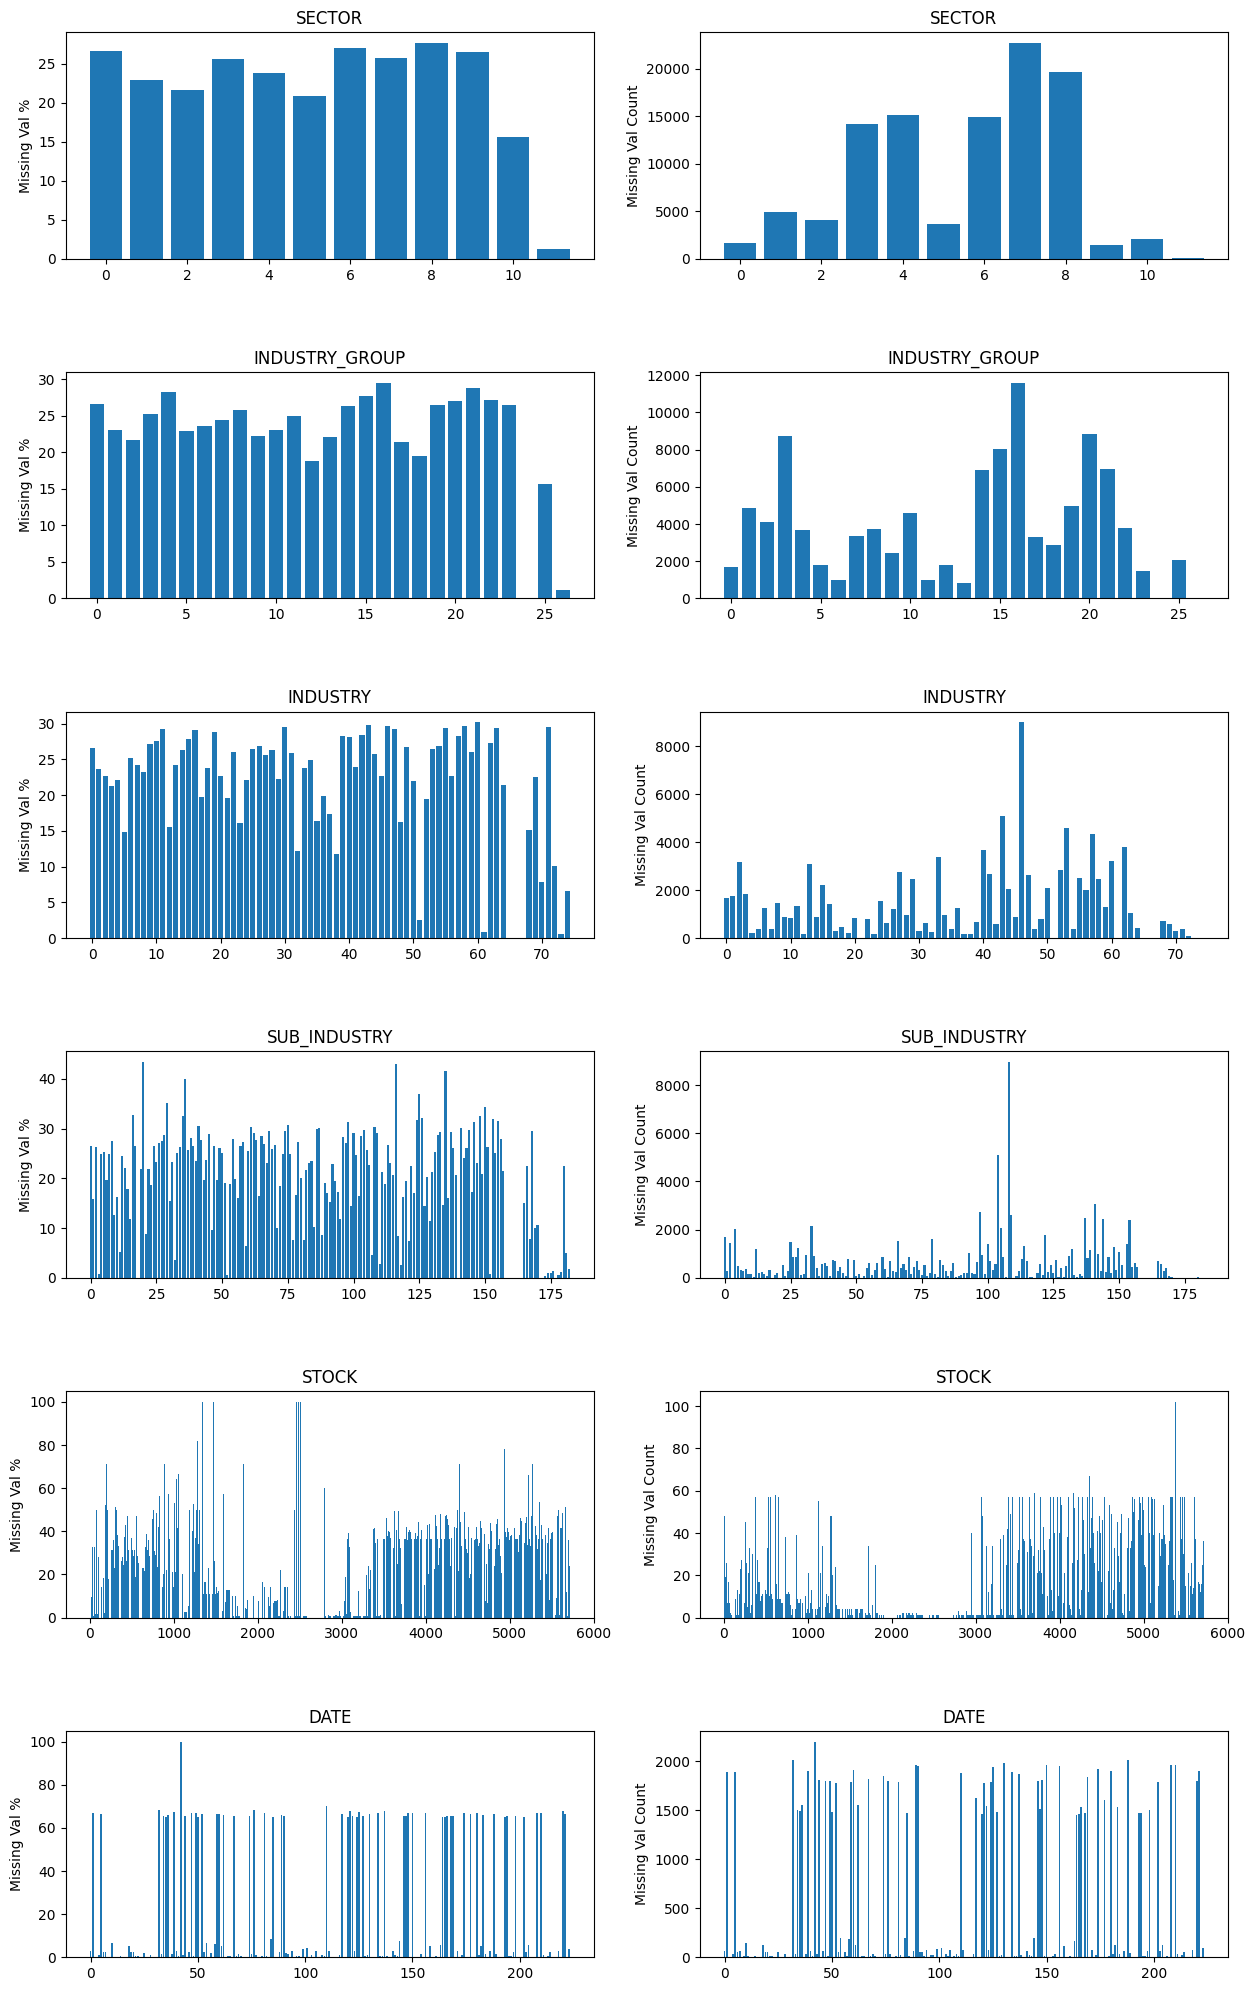

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,25))
plt.subplots_adjust(hspace=0.5)
for i,category in enumerate(['SECTOR', 'INDUSTRY_GROUP', 'INDUSTRY', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(6,2,2 * i + 1)
    plt.title(category)
    plt.bar(train[category].sort_values().unique(),
            [(train[train[category]==sub_category].isna().sum(axis=1)>0).sum()/len(train[train[category]==sub_category])*100 for sub_category in train[category].sort_values().unique()])

    plt.ylabel('Missing Val %')

    plt.subplot(6,2,2 * i + 2)
    plt.title(category)
    plt.bar(train[category].sort_values().unique(),
            [(train[train[category]==sub_category].isna().sum(axis=1)>0).sum() for sub_category in train[category].sort_values().unique()])

    plt.ylabel('Missing Val Count')
plt.show()


**Missing data population across different categories**

We found that missing data is more or less evenly distributed in sector groups, except that the sector 11 has obviously less missing data. But the data number in sector 11 is far less than others. So we don't do special treatment to different group when filling in the missing data.

It's very interesting that the missing data proportion at some specific days exhibit similar results in the last figure. It means that during these days, the same number of stocks have missing values. This may due to the fact we have public holidays before and the VOLUME can not be determined.

In [10]:
stat_20_days = pd.DataFrame(columns=['Day Before', 'RET_mean', 'RET_median', 'RET_std', 'VOLUME_mean', 'VOLUME_median', 'VOLUME_std'])
for day in range(1,21):
    stat_20_days.loc[day] =[int(day), eda_train[f'RET_{day}'].mean(), eda_train[f'RET_{day}'].median(), eda_train[f'RET_{day}'].std(), 
                      eda_train[f'VOLUME_{day}'].mean(), eda_train[f'VOLUME_{day}'].median(), eda_train[f'VOLUME_{day}'].std()]
stat_20_days

,Day Before,RET_mean,RET_median,RET_std,VOLUME_mean,VOLUME_median,VOLUME_std
1,1.0,0.001383,0.000637,0.031311,-0.071502,-0.282609,3.038658
2,2.0,0.000973,0.000401,0.030987,-0.075230,-0.278437,2.635549
3,3.0,0.002153,0.000909,0.031332,-0.097235,-0.278277,2.490831
4,4.0,-0.000679,-0.000495,0.031224,-0.088976,-0.275435,1.730786
5,5.0,0.000358,0.000000,0.031886,-0.092163,-0.281238,1.848977
6,6.0,-0.000261,0.000000,0.031311,-0.100510,-0.288125,1.689065
7,7.0,0.000330,0.000000,0.030966,-0.084714,-0.284789,1.839735
8,8.0,0.000124,-0.000169,0.031707,-0.087037,-0.289772,1.595809
9,9.0,-0.000621,0.000000,0.032899,-0.090863,-0.298185,1.857236
10,10.0,0.000005,0.000000,0.031689,-0.092151,-0.295750,1.653412


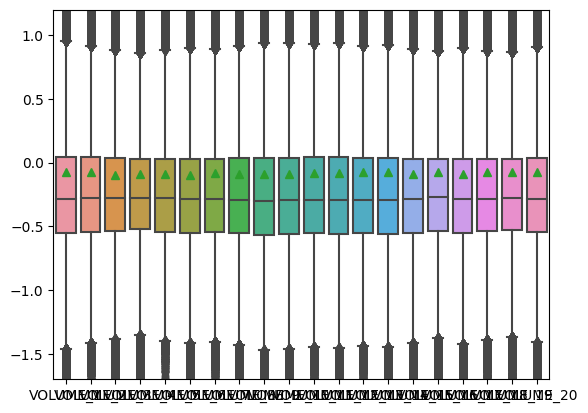

In [12]:
# Visualization of volume stats for each day
sns.boxplot(eda_train[[f'VOLUME_{day}' for day in range(1,21)]], showmeans=True)
plt.ylim((-1.7,1.2))
plt.show()

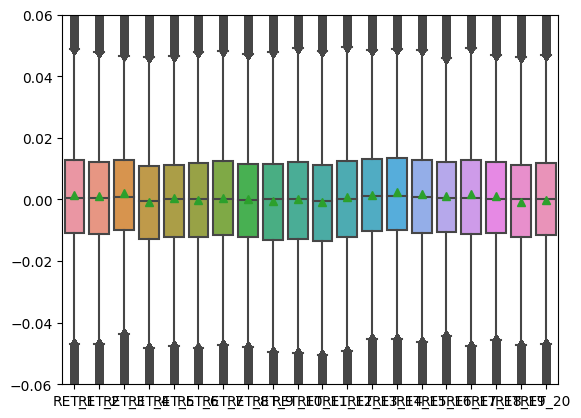

In [13]:
# Visualization of return stats for each day
sns.boxplot(eda_train[[f'RET_{day}' for day in range(1,21)]], showmeans=True)
plt.ylim((-0.06,0.06))
plt.show()

**RETURN and VOLUME stats**

It can be seen that median number of volume deviate from 0. Therefore, We cannot fill every missing data with zero. Instead, using median is a better choice. This meets with our task objective because we are always try to separate the number above the median return from the below ones. Filling the missing data with zero may introduce bias.

## RETURN and VOLUME distribution

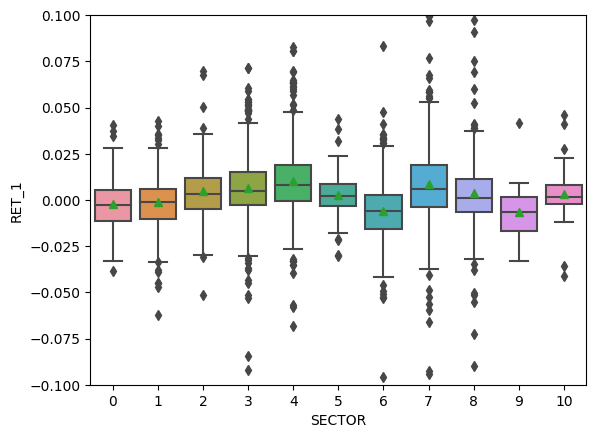

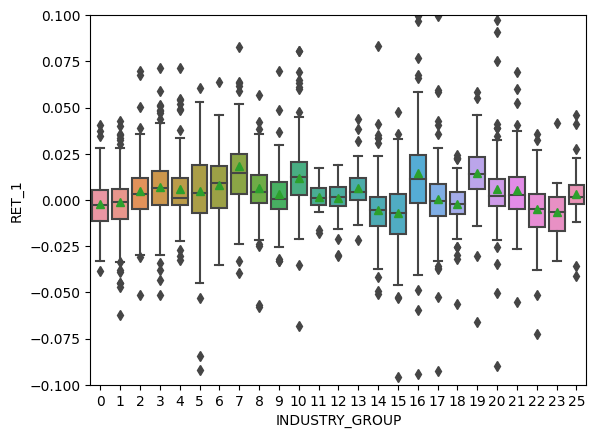

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

arbitary_date = eda_train[eda_train['DATE']==4]

sns.boxplot(x='SECTOR', y='RET_1', data=arbitary_date, showmeans=True)
plt.ylim((-0.1,0.1))
plt.show()

sns.boxplot(x='INDUSTRY_GROUP', y='RET_1', data=arbitary_date, showmeans=True)
plt.ylim((-0.1,0.1))
plt.show()


**RETURN group by SECTOR/INDUSTRY**

Suppose we are predicting the return_1, the above group by result shows returns within same SECTOR/INDUSTRY have the same trend of going up or down. So that we probability need to create features that represent the group characteristics. (either group by SECTOR, INDUSTRY_GROUP, INDUSTRY, or SUB_INDUSTRY) 

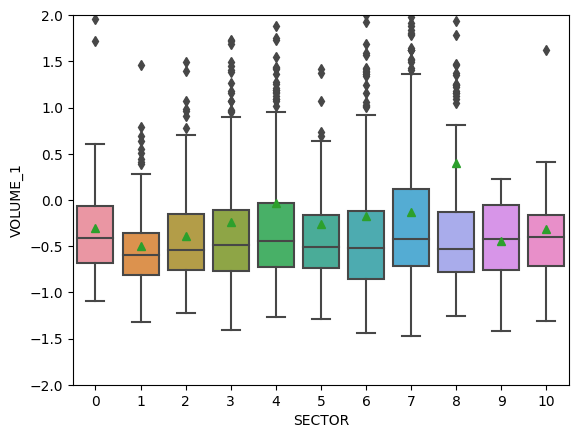

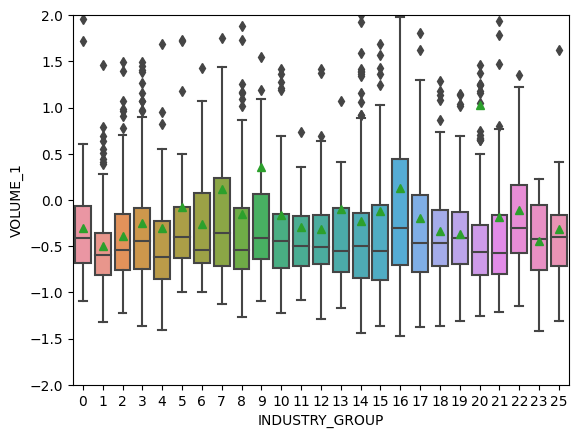

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

arbitary_date = eda_train[eda_train['DATE']==4]

sns.boxplot(x='SECTOR', y='VOLUME_1', data=arbitary_date, showmeans=True)
plt.ylim((-2,2))
plt.show()

sns.boxplot(x='INDUSTRY_GROUP', y='VOLUME_1', data=arbitary_date, showmeans=True)
plt.ylim((-2,2))
plt.show()

**VOLUME group by SECTOR/INDUSTRY**

The same rules can be applied to volume，but the phenomenon is less obvious.

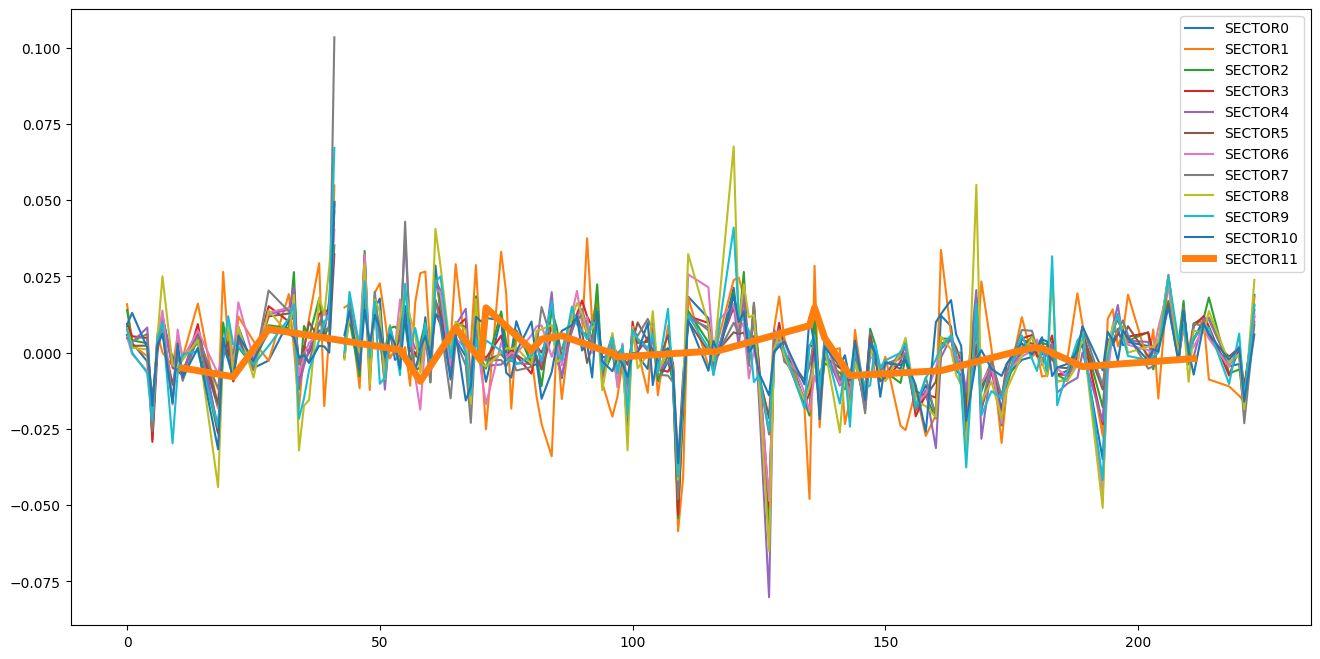

In [71]:
plt.figure(figsize=(16,8))
# for d in sorted(train['SECTOR'].unique()):
for d in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    plt.plot(eda_train[eda_train['SECTOR']==d].groupby(['DATE'])[['RET_1']].median('RET_1'), label = f'SECTOR{d}')
plt.plot(eda_train[eda_train['SECTOR']==11].groupby(['DATE'])[['RET_1']].median('RET_1'), linewidth=5, label = f'SECTOR{11}')
plt.legend()

**Daily RETURN_1 group by SECTOR**

All the stock return within group 0-10 seems to have possitive correlation to each other except for the stocks in sector 11. We can see that stock return in sector 11 is less affected by the market and seems not to have a correlation to others. It has a comparably flat return across the time. This provides a direction for the prediction. Maybe we can train sub models to predict data from different sectors. 

## Correlation among variables

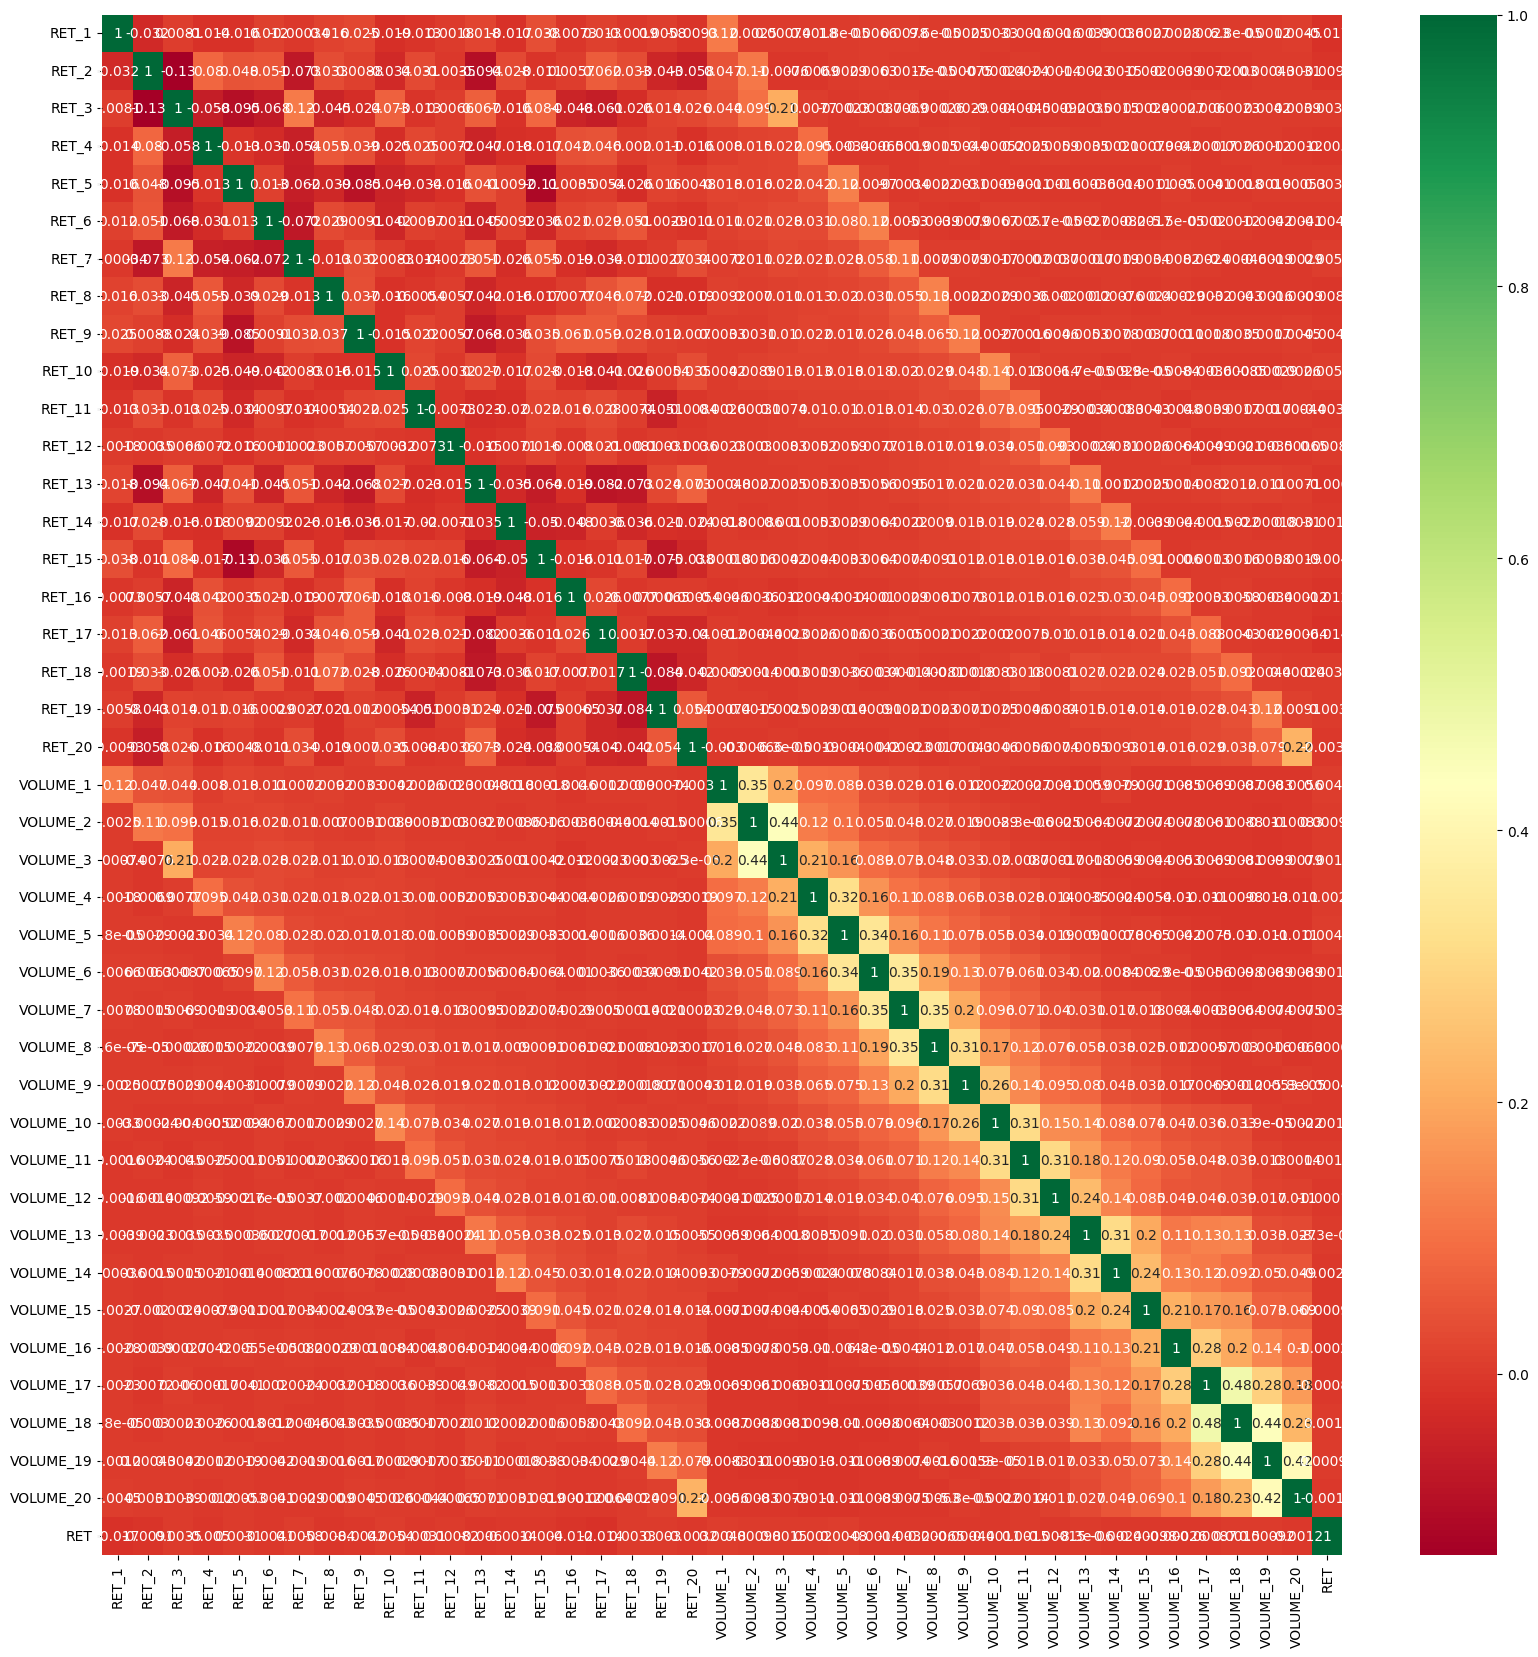

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
# plot heat map
features = [f'RET_{i}' for i in range(1, 21)]
features += [f'VOLUME_{i}' for i in range(1, 21)]
features += ['RET']
g=sns.heatmap(eda_train[features].corr(),annot=True,cmap="RdYlGn")

**Correlation among variables**

No feature has a strong correlation to the ''RET'' feature. VOLUME_(i) seems to have an obscure lag effect on VOLUME_(i-1).

# Feature Engineering

After reviewing financial literatures and asking for the chatgpt to provide some insights for stock movement prediction, I came up with the following new features in this project.

## Clean the data and fill in the missing data

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Drop the data with the majority of return values missing
days = 20
features = [f'RET_{day}' for day in range(1, days + 1)]
drop_data = train[(train[features].isna().sum(axis=1)/(train[features].shape[1]) >= 0.5)][features]
train.drop(index=drop_data.index, inplace=True)

In [5]:
# Fill in the missing data with the median number of that column
for feature in ['VOLUME', 'RET']:
    for column in [f'{feature}_{day}' for day in range(1,21)]:
        for data in [train, test]:
            data[column] = data[column].fillna(data[column].median())

In [7]:
# Check if missing values are filled
train.isna().sum()

DATE              0
STOCK             0
INDUSTRY          0
INDUSTRY_GROUP    0
SECTOR            0
SUB_INDUSTRY      0
RET_1             0
VOLUME_1          0
RET_2             0
VOLUME_2          0
RET_3             0
VOLUME_3          0
RET_4             0
VOLUME_4          0
RET_5             0
VOLUME_5          0
RET_6             0
VOLUME_6          0
RET_7             0
VOLUME_7          0
RET_8             0
VOLUME_8          0
RET_9             0
VOLUME_9          0
RET_10            0
VOLUME_10         0
RET_11            0
VOLUME_11         0
RET_12            0
VOLUME_12         0
RET_13            0
VOLUME_13         0
RET_14            0
VOLUME_14         0
RET_15            0
VOLUME_15         0
RET_16            0
VOLUME_16         0
RET_17            0
VOLUME_17         0
RET_18            0
VOLUME_18         0
RET_19            0
VOLUME_19         0
RET_20            0
VOLUME_20         0
RET               0
dtype: int64

In [92]:
test.isna().sum()

DATE              0
STOCK             0
INDUSTRY          0
INDUSTRY_GROUP    0
SECTOR            0
SUB_INDUSTRY      0
RET_1             0
VOLUME_1          0
RET_2             0
VOLUME_2          0
RET_3             0
VOLUME_3          0
RET_4             0
VOLUME_4          0
RET_5             0
VOLUME_5          0
RET_6             0
VOLUME_6          0
RET_7             0
VOLUME_7          0
RET_8             0
VOLUME_8          0
RET_9             0
VOLUME_9          0
RET_10            0
VOLUME_10         0
RET_11            0
VOLUME_11         0
RET_12            0
VOLUME_12         0
RET_13            0
VOLUME_13         0
RET_14            0
VOLUME_14         0
RET_15            0
VOLUME_15         0
RET_16            0
VOLUME_16         0
RET_17            0
VOLUME_17         0
RET_18            0
VOLUME_18         0
RET_19            0
VOLUME_19         0
RET_20            0
VOLUME_20         0
dtype: int64

## Create new features

In [6]:
# Feature engineering
new_features = []

**Conditional aggregated features, mean daily return by groups**

In [7]:
shifts = range(1, 21)
statistics = ['mean']
gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE'], ['INDUSTRY', 'DATE'], ['SUB_INDUSTRY', 'DATE']]
target_features = ['RET']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{stat}_{target_feature}_{shift}_{tmp_name}'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data.groupby(gb_features)[feat].transform(stat)

**Mean and std of each stock's return and volume for each week (20 days of data equals 4 weeks)**

In [8]:
weeks = 4
statistics = ['mean', 'std']
target_features = ['RET', 'VOLUME'] 
for target_feature in target_features:
    for stat in statistics:
        for week in range(weeks):
            name = f'{stat}_{target_feature}_STOCK_WEEK_{week+1}'
            new_features.append(name)
            for data in [train, test]:
                if stat == 'mean':
                    data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1)
                elif stat == 'std':
                    data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].std(axis=1)

**Relative stock's RETURN and VOLUME compared to its groups in each week**

In [9]:
shifts = [1, 2, 3, 4] 
statistics = ['sum']
gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE'], ['INDUSTRY', 'DATE'], ['SUB_INDUSTRY', 'DATE']]
target_features = ['mean_VOLUME_STOCK_WEEK', 'mean_RET_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_TO_TOTAL_{tmp_name}'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform(stat)

**Momentum**

$$
Momentum_{\_RET}=RET_1 - mean(RET_2, RET_3,...,RET_i)
$$

$$
Momentum_{\_VOLUME}=VOLUME_1 - mean(VOLUME_2, VOLUME_3,...,VOLUME_i)
$$

In [10]:
# Calculate the momentum to observe the trend of return and volume
weeks = [1, 2, 3, 4]
targets = ['RET', 'VOLUME']
gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE'], ['INDUSTRY', 'DATE'], ['SUB_INDUSTRY', 'DATE']]
for target in targets:
    for gb_features in gb_features_list:
        for week in weeks: 
            window_size = 5*week
            name = f'momentum_{target}_{window_size}_DAY_{gb_features[0]}'
            new_features.append(name)
            for data in [train, test]:
                _data = data.copy()
                rolling_mean_target = _data.groupby(gb_features)[[f'{target}_{day}' for day in range(2, window_size+1)]].mean()
                target_1_mean = _data.groupby(gb_features)[[f'{target}_1']].mean()
                target_1_mean_aligned, rolling_mean_target_aligned = target_1_mean.align(rolling_mean_target, axis=0, level=gb_features[0])
                target_momentum = target_1_mean_aligned.sub(rolling_mean_target_aligned.mean(axis=1), axis=0)
                target_momentum.rename(columns={f'{target}_1': name},inplace=True)
                placeholder = _data.join(target_momentum, on=gb_features, how='left')
                data[name] = placeholder[name]

**Volatility: Compute the standard deviation of the averages to measure volatility. (conditioned on groups)**

In [11]:
weeks = [1, 2, 3, 4]
targets = ['RET', 'VOLUME']
gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE'], ['INDUSTRY', 'DATE'], ['SUB_INDUSTRY', 'DATE']]
for week in weeks: 
    window_size = 5*week
    for gb_features in gb_features_list:
        for target in targets: 
            name = f'mean_volatility_{target}_{window_size}_DAY_{gb_features[0]}'
            new_features.append(name)
            for data in [train, test]:
                rolling_std_target = data.groupby(gb_features)[[f'{target}_{day}' for day in range(1,window_size+1)]].mean().std(axis=1).to_frame(name)
                placeholder = data.join(rolling_std_target, on=gb_features, how='left')
                data[name] = placeholder[name]

**Relative Strength Index (RSI)**

The RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100.

$$ \text{RSI} = 100 - \frac{100}{1 + RS} $$
$$ RS = \frac{\text{Average Gain}}{\text{Average Loss}} $$


In [12]:
# We are now going to add the relative strength index per sector. The RSI measures the speed and change of price movements.
targets = ["RET"]
weeks = [1, 2, 3, 4]
gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE'], ['INDUSTRY', 'DATE'], ['SUB_INDUSTRY', 'DATE']]

for target in targets:
    for week in weeks:
        window_size = 5*week
        for gb_features in gb_features_list:
            name = f"RSI_{gb_features[0]}_DATE_{window_size}"
            new_features.append(name)
            for data in [train, test]:
                _data = data.copy()
                avg_gain_group_day = _data.groupby(gb_features)[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x>0].mean(), axis=1)
                avg_loss_group_day = _data.groupby(gb_features)[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x<0].mean(), axis=1).abs()
                rs_group_day = avg_gain_group_day/avg_loss_group_day
                rsi_group_date = 100 - 100/(1+rs_group_day)
                placeholder = _data.join(rsi_group_date.to_frame(name), on=gb_features, how='left')
                data[name] = placeholder[name]

**Advance-Decline Line ADL**
$$
ADL = \#Advancing~Stocks - \#Declining~Stocks
$$

In [13]:
weeks = [1, 2, 3, 4]
gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE'], ['INDUSTRY', 'DATE'], ['SUB_INDUSTRY', 'DATE']]
for week in weeks:
    window_size = 5*week
    for gb_features in gb_features_list:
        name = f'sum_ADL_{window_size}_DAY_{gb_features[0]}'
        new_features.append(name)
        for data in [train, test]:
            _data = data.copy()
            sum_adl = ((_data.groupby(gb_features)[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x>0).sum()) - (_data.groupby(gb_features)[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x<0).sum())).sum(axis=1)
            placeholder = _data.join(sum_adl.to_frame(name), on=gb_features, how='left')
            data[name] = placeholder[name]

In [15]:
for feature in new_features:
    print(feature)
print('Total number new features', len(new_features))

mean_RET_1_SECTOR_DATE
mean_RET_2_SECTOR_DATE
mean_RET_3_SECTOR_DATE
mean_RET_4_SECTOR_DATE
mean_RET_5_SECTOR_DATE
mean_RET_6_SECTOR_DATE
mean_RET_7_SECTOR_DATE
mean_RET_8_SECTOR_DATE
mean_RET_9_SECTOR_DATE
mean_RET_10_SECTOR_DATE
mean_RET_11_SECTOR_DATE
mean_RET_12_SECTOR_DATE
mean_RET_13_SECTOR_DATE
mean_RET_14_SECTOR_DATE
mean_RET_15_SECTOR_DATE
mean_RET_16_SECTOR_DATE
mean_RET_17_SECTOR_DATE
mean_RET_18_SECTOR_DATE
mean_RET_19_SECTOR_DATE
mean_RET_20_SECTOR_DATE
mean_RET_1_INDUSTRY_GROUP_DATE
mean_RET_2_INDUSTRY_GROUP_DATE
mean_RET_3_INDUSTRY_GROUP_DATE
mean_RET_4_INDUSTRY_GROUP_DATE
mean_RET_5_INDUSTRY_GROUP_DATE
mean_RET_6_INDUSTRY_GROUP_DATE
mean_RET_7_INDUSTRY_GROUP_DATE
mean_RET_8_INDUSTRY_GROUP_DATE
mean_RET_9_INDUSTRY_GROUP_DATE
mean_RET_10_INDUSTRY_GROUP_DATE
mean_RET_11_INDUSTRY_GROUP_DATE
mean_RET_12_INDUSTRY_GROUP_DATE
mean_RET_13_INDUSTRY_GROUP_DATE
mean_RET_14_INDUSTRY_GROUP_DATE
mean_RET_15_INDUSTRY_GROUP_DATE
mean_RET_16_INDUSTRY_GROUP_DATE
mean_RET_17_INDUSTRY_GROUP

## Feature selection

There are 224 new features created. A lot of them are correlated. I only want to retain one feature for every group of correlated features. Specifically, one feature for momentum, volatility, RSI, and ADL. And top several features for mean return and volume. I used the random forest with 4-fold to select the best performing features.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X_train = train[features]
y_train = train[target]
X_test = test[features]

rf_params = {
    'n_estimators': 500,
    'max_depth': 8,
    'criterion': 'gini',
    'random_state': 0,
    'n_jobs': -1
}
score_all = []
best_score = 0
target = 'RET'
n=0
for l1 in range(5, 6): # top l1 days return and volume
    for n1 in ['SECTOR']: # top l2 days mean return of groupby
        for l2 in range(3, 4):
            for l3 in range(4): # top l3 weeks mean and std return and volume
                for n2 in ['SECTOR',]: # top l4 week normalized volume return
                    for l4 in range(3, 4):
                        for n3 in ['SECTOR']: # top l5 week momentum
                            for l5 in range(4):
                                for n4 in ['SECTOR']: # top l6 week volatility
                                    for l6 in range(4):     
                                        for n5 in ['SECTOR']: # top l7 week RSI
                                            for l7 in range(4):  
                                                for n6 in ['SECTOR']: # top l8 week ADL
                                                    for l8 in range(4):
                                                        features = ['RET_%d' % (i + 1) for i in range(l1)]
                                                        features += ['VOLUME_%d' % (i + 1) for i in range(l1)]
                                                        features += ['mean_RET_{}_{}_DATE'.format(day + 1, n1) for day in range(l2 + 1)]
                                                        features += ['mean_RET_STOCK_WEEK_{}'.format(week + 1) for week in range(l3 + 1)]
                                                        features += ['std_RET_STOCK_WEEK_{}'.format(week + 1) for week in range(l3 + 1)]
                                                        features += ['mean_VOLUME_STOCK_WEEK_{}'.format(week + 1) for week in range(l3 + 1)]
                                                        features += ['std_VOLUME_STOCK_WEEK_{}'.format(week + 1) for week in range(l3 + 1)]
                                                        features += ['mean_RET_STOCK_WEEK_{}_TO_TOTAL_{}_DATE'.format(week + 1, n2) for week in range(l4 + 1)]
                                                        features += ['mean_VOLUME_STOCK_WEEK_{}_TO_TOTAL_{}_DATE'.format(week + 1, n2) for week in range(l4 + 1)]
                                                        features += ['momentum_RET_{}_DAY_{}'.format((l5 + 1) * 5, n3)]
                                                        features += ['momentum_VOLUME_{}_DAY_{}'.format((l5 + 1) * 5, n3)]
                                                        features += ['mean_volatility_RET_{}_DAY_{}'.format((l6 + 1) * 5, n4)]
                                                        features += ['mean_volatility_VOLUME_{}_DAY_{}'.format((l6 + 1) * 5, n4)]
                                                        features += ['RSI_{}_DATE_{}'.format(n5, (l7 + 1) * 5)]
                                                        features += ['sum_ADL_{}_DAY_{}'.format((l8 + 1) * 5, n6)]                             

                                                        X_train = train[features]
                                                        y_train = train[target]
                                                        # X_test = test[features]
                                                        
                                                        train_dates = train['DATE'].unique()
                                                        test_dates = test['DATE'].unique()
                                                        
                                                        n_splits = 4
                                                        scores = []
                                                        models = []
                                                        
                                                        splits = KFold(n_splits=n_splits, random_state=0,
                                                                       shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train / test
                                                        
                                                        for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
                                                            local_train_dates = train_dates[local_train_dates_ids]
                                                            local_test_dates = train_dates[local_test_dates_ids]
                                                        
                                                            local_train_ids = train['DATE'].isin(local_train_dates)
                                                            local_test_ids = train['DATE'].isin(local_test_dates)
                                                        
                                                            X_local_train = X_train.loc[local_train_ids]
                                                            y_local_train = y_train.loc[local_train_ids]
                                                            X_local_test = X_train.loc[local_test_ids]
                                                            y_local_test = y_train.loc[local_test_ids]
                                                        
                                                            model = RandomForestClassifier(**rf_params)
                                                            model.fit(X_local_train, y_local_train.values.reshape(-1))
                                                        
                                                            y_local_pred = model.predict_proba(X_local_test)[:, 1]
                                                            
                                                            sub = train.loc[local_test_ids].copy()
                                                            sub['pred'] = y_local_pred
                                                            y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values
                                                        
                                                            models.append(model)
                                                            score = accuracy_score(y_local_test, y_local_pred)
                                                            scores.append(score)
                                                            # print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")
                                                        
                                                        mean = np.mean(scores)*100
                                                        std = np.std(scores)*100
                                                        if mean > best_score:
                                                            best_score = mean
                                                            best_params = features
                                                        score_all.append([scores, features])
                                                        u = (mean + std)
                                                        l = (mean - std)
                                                        print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')
print('best score', best_score)
print(best_params)

Accuracy: 52.08% [51.47 ; 52.70] (+- 0.61) RET_5_day_momentum_SECTOR 5_day_mean_RET_vola_SECTOR RSI_SECTOR_DATE_10 10_Day_Sum_ADL_SECTOR
Accuracy: 52.14% [51.57 ; 52.81] (+- 0.62) RET_5_day_momentum_SECTOR 5_day_mean_RET_vola_SECTOR RSI_SECTOR_DATE_10 15_Day_Sum_ADL_SECTOR
Accuracy: 51.98% [51.32 ; 52.63] (+- 0.65) RET_5_day_momentum_SECTOR 5_day_mean_RET_vola_SECTOR RSI_SECTOR_DATE_10 20_Day_Sum_ADL_SECTOR
Accuracy: 52.07% [51.35 ; 52.78] (+- 0.72) RET_5_day_momentum_SECTOR 5_day_mean_RET_vola_SECTOR RSI_SECTOR_DATE_15 5_Day_Sum_ADL_SECTOR
Accuracy: 52.03% [51.47 ; 52.59] (+- 0.56) RET_5_day_momentum_SECTOR 5_day_mean_RET_vola_SECTOR RSI_SECTOR_DATE_15 10_Day_Sum_ADL_SECTOR
Accuracy: 52.12% [51.43 ; 52.88] (+- 0.72) RET_5_day_momentum_SECTOR 5_day_mean_RET_vola_SECTOR RSI_SECTOR_DATE_15 15_Day_Sum_ADL_SECTOR
...

**Select the final features**

In [16]:
target = 'RET'
new_features = [f'mean_RET_{i}_SECTOR_DATE' for i in range(1, 5)]
new_features += [f'mean_RET_STOCK_WEEK_{i}' for i in range(1, 5)]
new_features += [f'std_RET_STOCK_WEEK_{i}' for i in range(1, 5)]
new_features += [f'mean_VOLUME_STOCK_WEEK_{i}' for i in range(1, 5)]
new_features += [f'std_VOLUME_STOCK_WEEK_{i}' for i in range(1, 5)]

new_features += [f'mean_VOLUME_STOCK_WEEK_{i}_TO_TOTAL_SECTOR_DATE' for i in range(1, 5)]
new_features += [f'mean_RET_STOCK_WEEK_{i}_TO_TOTAL_SECTOR_DATE' for i in range(1, 5)]

new_features += ['momentum_RET_10_DAY_SECTOR']
new_features += ['momentum_VOLUME_10_DAY_SECTOR']

new_features += ['mean_volatility_RET_10_DAY_SECTOR']
new_features += ['mean_volatility_VOLUME_10_DAY_SECTOR']

new_features += ['RSI_SECTOR_DATE_20']
new_features += ['sum_ADL_5_DAY_SECTOR']

n_shifts = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features

train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,mean_RET_STOCK_WEEK_1_TO_TOTAL_SECTOR_DATE,mean_RET_STOCK_WEEK_2_TO_TOTAL_SECTOR_DATE,mean_RET_STOCK_WEEK_3_TO_TOTAL_SECTOR_DATE,mean_RET_STOCK_WEEK_4_TO_TOTAL_SECTOR_DATE,momentum_RET_10_DAY_SECTOR,momentum_VOLUME_10_DAY_SECTOR,mean_volatility_RET_10_DAY_SECTOR,mean_volatility_VOLUME_10_DAY_SECTOR,RSI_SECTOR_DATE_20,sum_ADL_5_DAY_SECTOR
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,...,0.016580,0.031106,-0.001557,-0.095186,0.007065,0.133418,0.010873,0.081617,53.224951,-43
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,-0.282609,-0.278437,-0.278277,-0.275435,-0.281238,...,0.017893,0.013381,-0.016516,-0.050570,0.004629,0.160778,0.013021,0.124051,42.078546,-263
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,...,0.003527,0.001551,-0.000281,0.007789,0.009124,0.005700,0.025154,0.085402,56.806133,-251
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,...,-0.014100,0.119514,0.228693,0.040345,0.021372,0.166425,0.012295,0.107518,44.708261,-88
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,...,-0.008586,-0.004614,0.022317,-0.304075,0.005308,-0.155035,0.007567,0.096248,54.587167,-56


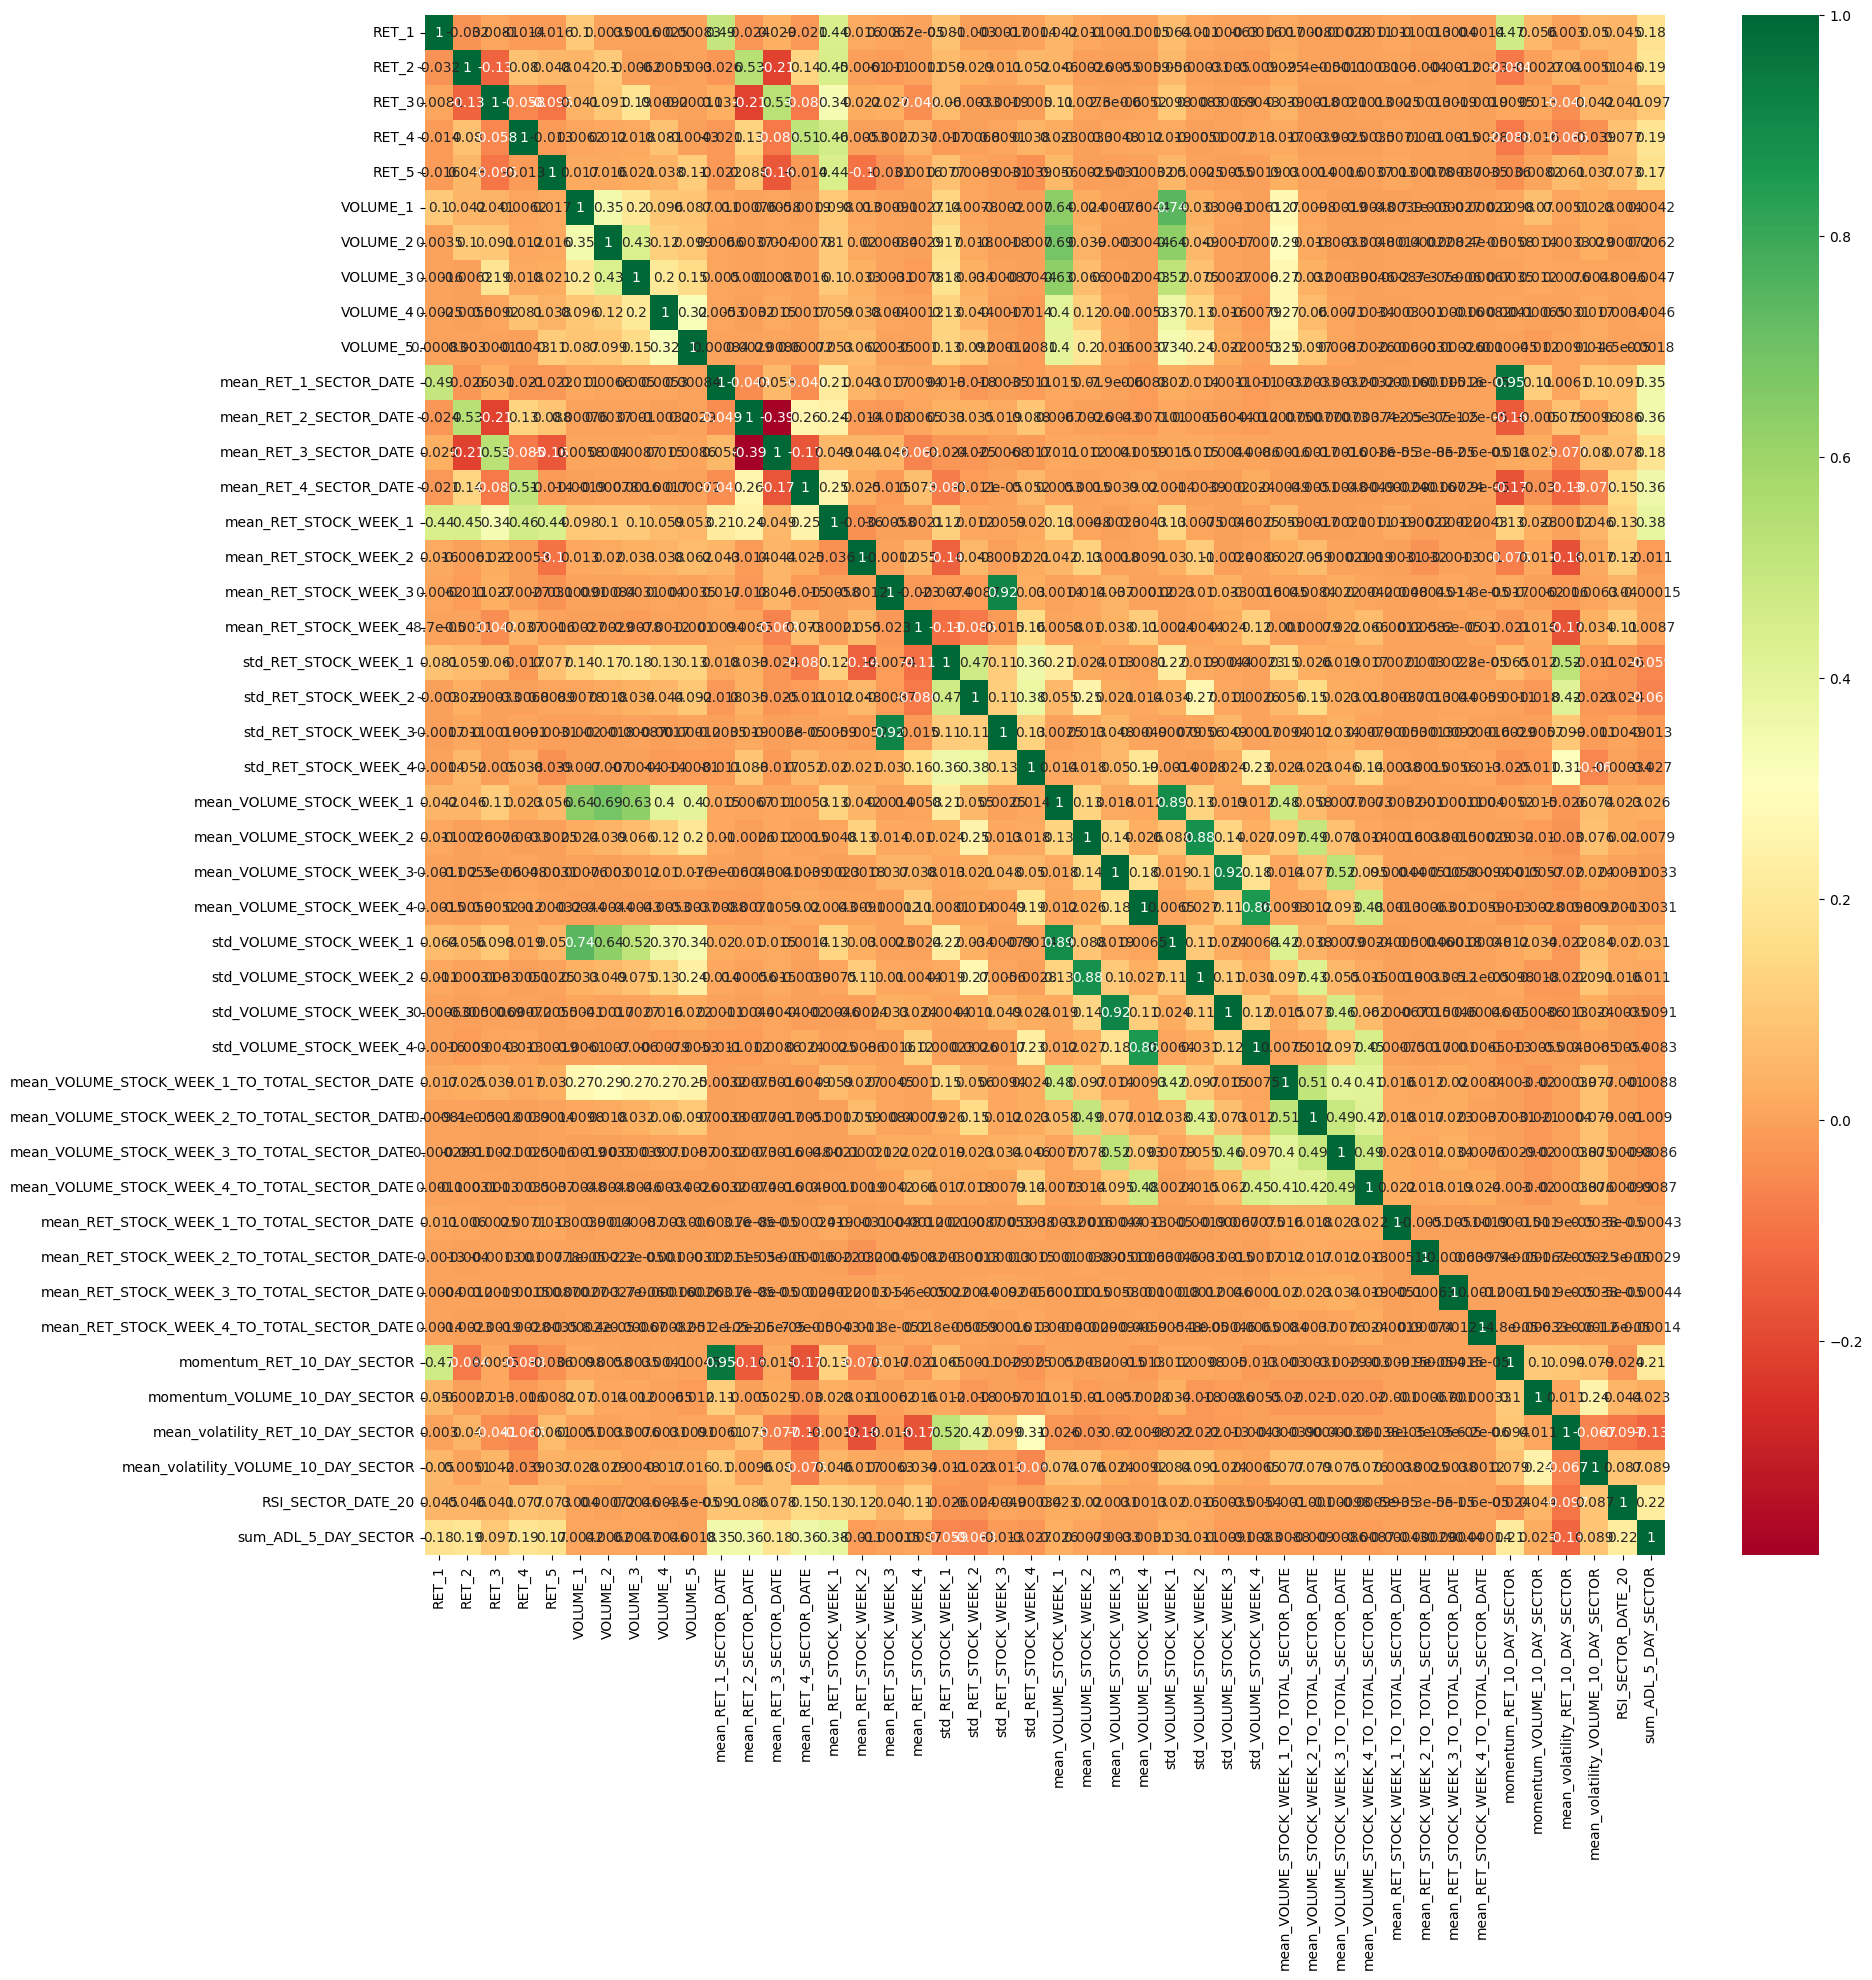

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

g=sns.heatmap(train[features].corr(),annot=True,cmap="RdYlGn")

# Model and local score

**Ideas of improvements**: Tune the RF hyperparameters, deal with the missing values, change the features, consider another model, ...

In [18]:
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
X_train = train[features]
y_train = train[target]
X_test = test[features]

# Below is random forest version

## GridSearchCV: Random forest

In [17]:
# Grouped k-fold by date
groups = train['DATE'].values
group_kfold = GroupKFold(n_splits=4)

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {"n_estimators"      : [400, 500, 600, 700, 800],
              "criterion"         : ['gini', "entropy"],
              "max_depth"         : [8, 10, 12, 14, 16]
}

clf = RandomForestClassifier(random_state=30, n_jobs=-1)

In [19]:
# grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=2)
import time
t1 = time.time()

opt = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, 
                   cv=group_kfold.split(X_train, y_train, groups), verbose=3, refit=False)

opt.fit(X_train, y_train)
t2 = time.time()
print('Time spent to train randomforest is', round((t2 - t1)/60, 2), 'min')

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Time spent to train randomforest is 60.05 min


**Run k-fold provided from the original benchmark file**

In [19]:
rf_params = {
    'n_estimators': 700,
    'max_depth': 14,
    'criterion': 'gini',
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train/test

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train.values.reshape(-1))

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.84%
Fold 2 - Accuracy: 51.52%
Fold 3 - Accuracy: 53.41%
Fold 4 - Accuracy: 51.84%
Accuracy: 52.15% [51.41 ; 52.89] (+- 0.74)


<Axes: >

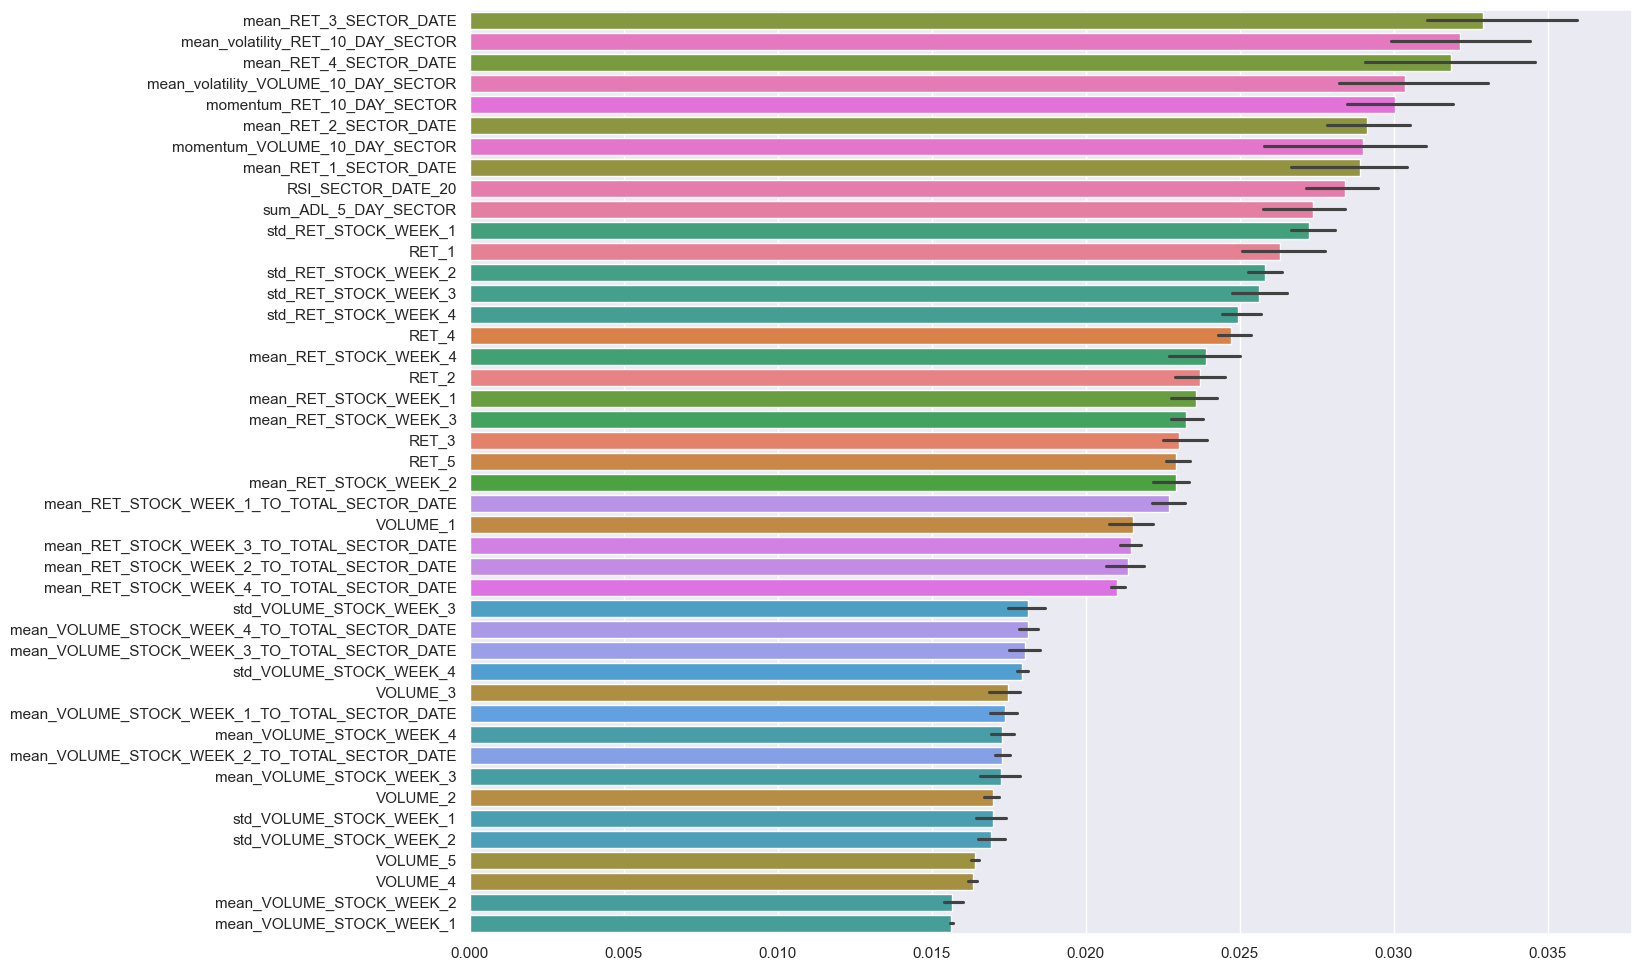

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)
sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

## Random forest final model

In [21]:
from datetime import *
myobj = datetime.now()

rf_params = {
    'n_estimators': 700,
    'max_depth': 14,
    'criterion': 'gini',
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./random_forest_{}{}{}{}.csv'.format(myobj.month, myobj.day, myobj.hour, myobj.minute), index=True, header=True)

0.7422412985571853


<Axes: >

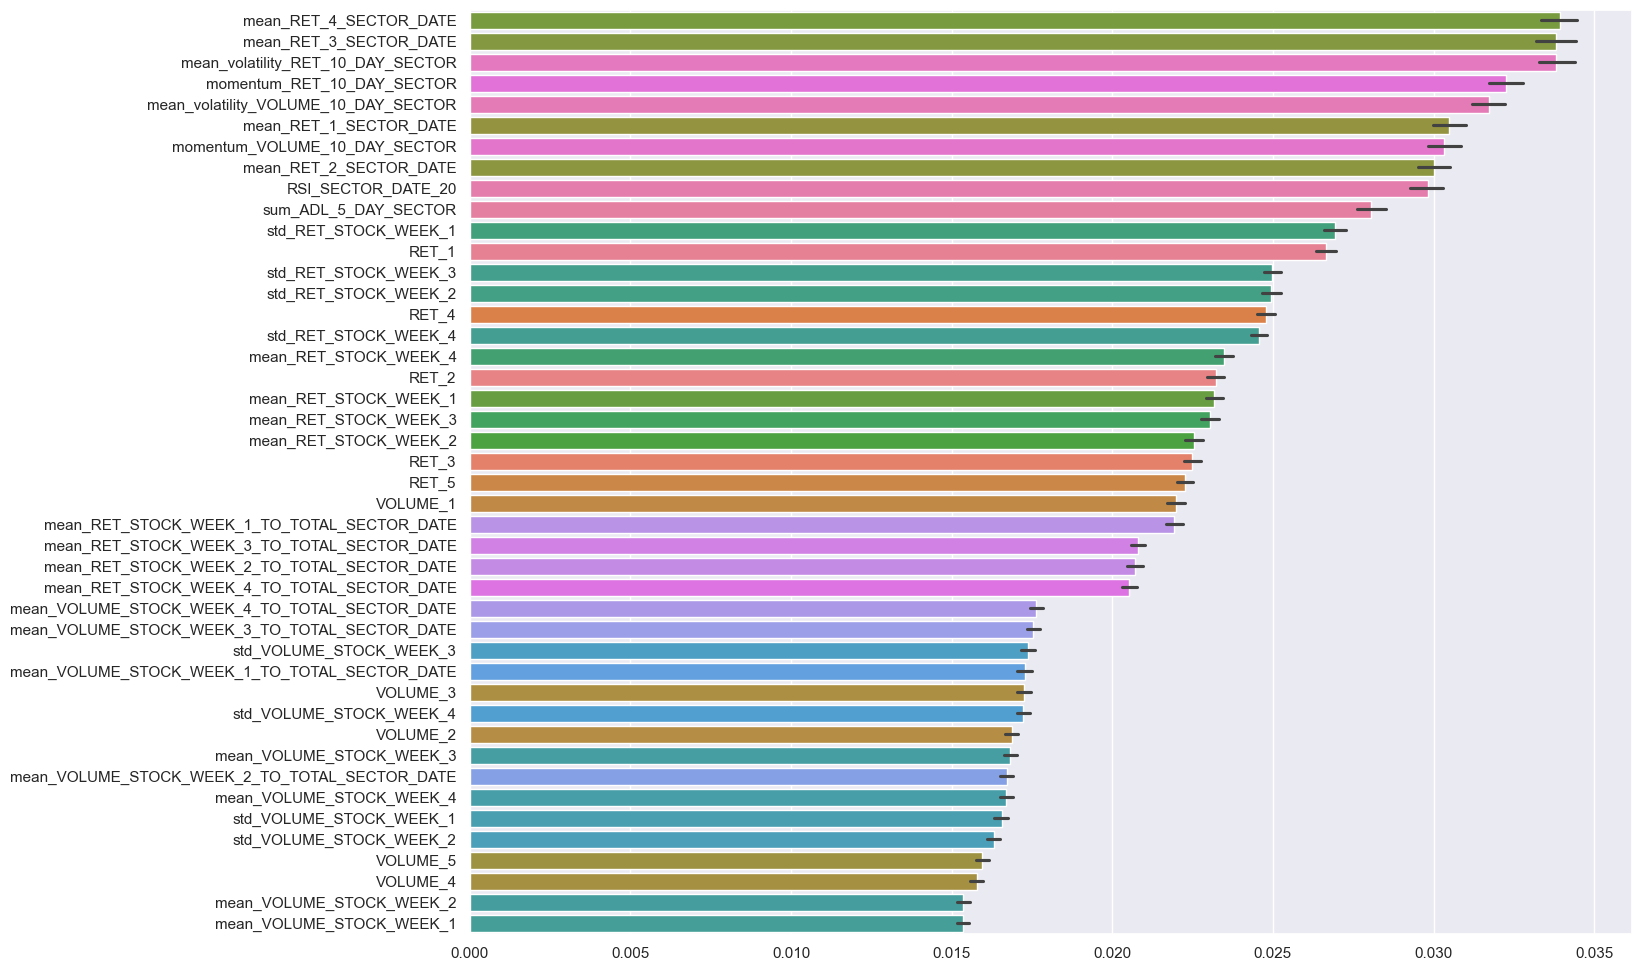

In [22]:
feature_importances = pd.DataFrame([mode.feature_importances_ for mode in model], columns=features)

sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

# Separate the dataset by sectors and train sub models

In [26]:
# First separate the data by user defined group in "subgroup"
subgroup = [[0,1,2,3,4,5,6,7,8,9,10],[11]]
group_feature = 'SECTOR'
dict_X_train = dict()
dict_y_train = dict()
dict_X_test = dict()
dict_model_params = dict()
dict_model = dict()

grouped_X_train = train.groupby(group_feature)
grouped_y_train = train.groupby(group_feature)
grouped_X_test = test.groupby(group_feature)

for idx, ls in enumerate(subgroup):
    dict_X_train[idx] = pd.concat([grouped_X_train.get_group(i) for i in ls])
    dict_y_train[idx] = pd.concat([grouped_y_train.get_group(i) for i in ls])
    dict_X_test[idx] = pd.concat([grouped_X_test.get_group(i) for i in ls])


## Implement GridSearchCV for each sub model and store the result

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

for key in dict_X_train.keys():
    groupby_day = dict_X_train[key]['DATE'].values
    groupby_day_kfold = GroupKFold(n_splits=4)
    # groupby_day_kfold.get_n_splits(dict_X_train[key], dict_y_train[key], groupby_day)
    


    param_grid = {"n_estimators"      : [300, 400, 500, 600, 700, 800],
                  "criterion"         : ["gini"],
                  "max_depth"         : [6, 8, 10, 12, 14, 16]
    }
    
    clf = RandomForestClassifier(random_state=30, n_jobs=-1)

    t1 = time.time()
    
    opt = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', n_jobs=-1, 
                       cv=groupby_day_kfold.split(dict_X_train[key][features], dict_y_train[key][target], groupby_day), verbose=3, refit=False)
    
    opt.fit(dict_X_train[key][features], dict_y_train[key][target])
    
    dict_model_params[key] = opt.best_params_
    
    t2 = time.time()
    print('Time spent to train randomforest group_{} is'.format(key), round((t2 - t1)/60, 2), 'min')


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Time spent to train randomforest group_0 is 6.55 min
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Time spent to train randomforest group_1 is 0.03 min


## Implement k-fold from original to test overall result

In [28]:

train_dates = train['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train / test

ensemble_model = dict()

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    
    X_local_train = train.loc[local_train_ids]
    y_local_train = train.loc[local_train_ids]
    
    X_local_test = train.loc[local_test_ids]
    y_local_test = train.loc[local_test_ids]

    specific_portion_X_train = dict()
    specific_portion_y_train = dict()
    specific_portion_X_test = dict()
    
    specific_portion_y_pred_test = dict()
    
        

    grouped_X_local_train = X_local_train.groupby(group_feature)
    grouped_y_local_train = y_local_train.groupby(group_feature)
    grouped_X_local_test = X_local_test.groupby(group_feature)
    
    # grouped_y_local_test = y_local_test.groupby(group_feature)

    for idx, ls in enumerate(subgroup):
        specific_portion_X_train[idx] = pd.concat([grouped_X_local_train.get_group(ii) for ii in ls])[features]
        specific_portion_y_train[idx] = pd.concat([grouped_y_local_train.get_group(ii) for ii in ls])[target]
        specific_portion_X_test[idx] = pd.concat([grouped_X_local_test.get_group(ii) for ii in ls])[features]
        
        # specific_portion_y_test[idx] = pd.concat([grouped_y_local_test.get_group(ii) for ii in ls])[target]
    
    ensemble_model[i] = dict()
    
    for key in dict_model_params.keys():

        ensemble_model[i][key] = RandomForestClassifier(random_state=0, n_jobs=-1, **dict_model_params[key])
        
        ensemble_model[i][key].fit(specific_portion_X_train[key], specific_portion_y_train[key])
        
        specific_portion_X_test[key]['pred'] = ensemble_model[i][key].predict_proba(specific_portion_X_test[key])[:, 1]
        
        
    y_pred_local_test = specific_portion_X_test[0]
    
    for ii in range(1,len(specific_portion_X_test)):
        y_pred_local_test=pd.concat([y_pred_local_test, specific_portion_X_test[ii]])
        
    # y_pred_local_test = pd.concat([ele1 for ele1 in specific_portion_y_pred_test.values()])
    
    y_pred_local_test = y_pred_local_test.merge(train,how='inner',on='ID')
    y_pred_local_test = y_pred_local_test.sort_values(by='ID')
    y_pred_local_test['pred'] = y_pred_local_test.groupby('DATE')['pred'].transform(
        lambda x: x > x.median()).values

    models.append(ensemble_model[i])
    score = accuracy_score(y_pred_local_test['RET'], y_pred_local_test['pred'])
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')


Fold 1 - Accuracy: 51.87%
Fold 2 - Accuracy: 51.50%
[CV 2/4] END criterion=gini, max_depth=12, n_estimators=500;, score=0.518 total time= 6.5min
[CV 1/4] END criterion=gini, max_depth=12, n_estimators=500;, score=0.488 total time=   1.7s
[CV 4/4] END criterion=gini, max_depth=12, n_estimators=500;, score=0.514 total time= 6.5min
[CV 2/4] END criterion=gini, max_depth=12, n_estimators=500;, score=0.400 total time=   1.7s
[CV 1/4] END criterion=gini, max_depth=12, n_estimators=500;, score=0.519 total time= 6.5min
[CV 3/4] END criterion=gini, max_depth=12, n_estimators=500;, score=0.489 total time=   1.7s
[CV 3/4] END criterion=gini, max_depth=12, n_estimators=500;, score=0.513 total time= 6.5min
[CV 4/4] END criterion=gini, max_depth=12, n_estimators=500;, score=0.493 total time=   1.7s
Fold 3 - Accuracy: 53.48%
Fold 4 - Accuracy: 51.89%
Accuracy: 52.19% [51.42 ; 52.95] (+- 0.76)


In [27]:
from datetime import *
myobj = datetime.now()

for key in dict_model_params.keys():
    model = RandomForestClassifier(random_state=0, n_jobs=-1, **dict_model_params[key])
    model.fit(dict_X_train[key][features], dict_y_train[key][target])
    dict_X_train[key]['pred'] = model.predict_proba(dict_X_train[key][features])[:, 1]
    dict_X_test[key]['pred'] = model.predict_proba(dict_X_test[key][features])[:, 1]
    
y_pred_train = dict_X_train[0]
for ii in range(1,len(dict_X_train)):
    y_pred_train=pd.concat([y_pred_train, dict_X_train[ii]])
#y_pred_train = y_pred_train.merge(train,how='inner',on='ID')
y_pred_train = y_pred_train.sort_values(by='ID')
y_pred_train_ = y_pred_train.groupby('DATE')['pred'].transform(
        lambda x: x > x.median()).values

print(accuracy_score(y_pred_train_,y_train))

y_pred_test = dict_X_test[0]
for ii in range(1,len(dict_X_test)):
    y_pred_test=pd.concat([y_pred_test, dict_X_test[ii]])
# y_pred_test = y_pred_test.merge(test,how='inner',on='ID')
y_pred_test = y_pred_test.sort_values(by='ID')
y_pred = y_pred_test.groupby('DATE')['pred'].transform(
        lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target
submission.to_csv('./random_forest_{}{}{}{}.csv'.format(myobj.month, myobj.day, myobj.hour, myobj.minute), index=True, header=True)

0.6680085219016234


# Below is th XGBboost version

In [24]:
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
groups = train['DATE'].values
group_kfold = GroupKFold(n_splits=4)

## GridsearchCV for XGBoost

In [26]:
params = {
# 'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
        'max_depth': [4, 6, 8, 10, 12, 14],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
        'reg_lambda': [0, 1, 2, 3]
        }

clf = XGBClassifier(n_estimators=600, n_jobs=-1)
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
import time

opt = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', n_jobs=-1, cv=group_kfold.split(X_train, y_train, groups), verbose=10, refit=False)

t1 = time.time()

opt.fit(X_train, y_train)

t2 = time.time()
print('Time spent to train XGBoost is', round((t2 - t1)/60, 2), 'min')


Fitting 4 folds for each of 36 candidates, totalling 144 fits
Time spent to train XGBoost is 11.62 min


**Final XGBoost parameters**

Fitting 4 folds for each of 36288 candidates, totalling 145152 fits
Time spent to train XGBoost is 3501.37 min


{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'max_depth': 7,
 'n_estimators': 500,
 'reg_lambda': 1,
 'subsample': 0.5}

In [25]:
# Use original provided k-fold to validate
xgb_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.01,
    'max_depth': 7,
    'n_estimators': 500,
    'reg_lambda': 1,
    'random_state': 0,
    'subsample': 0.5
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]


    model = XGBClassifier(**xgb_params)
    
    model.fit(X_local_train, y_local_train)
    # model = XGBClassifier(**xgb_params)
    # model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.82%
Fold 2 - Accuracy: 52.08%
Fold 3 - Accuracy: 53.22%
Fold 4 - Accuracy: 51.67%
Accuracy: 52.19% [51.59 ; 52.80] (+- 0.61)


## Generate the XGBoost final result

The same parameters of the xgboost model are considered.

In [31]:
from datetime import *
myobj = datetime.now()

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]


sub = train.copy()
sub['pred'] = opt.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

y_pred = opt.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./xgboost_{}{}{}{}.csv'.format(myobj.month, myobj.day, myobj.hour, myobj.minute), index=True, header=True)

0.6423131150336625


# Future work
## Data augmentation
Currently, we only have 400K training data which may not be enough. We can technically separate the data to different segments. For example, we use Day_2 to Day_6 data to predict Day_1. Further, we can use Day_3 to Day_7 data to predict Day_2. And so on, we can use any Day_i to Day_(i+5) data to predict Day_(i-1), assuming only former 5 days' data maining affecting the stock movement. In such way, we can augment the data to more than 10X times than before. In such manner, we can anticipate to train a neutral network or improve the performance of current models.

## Update on Dec. 29th
Due to the curiosity, I augmented the data based on my thought above. The performance further boosted and I ranked 15th among 700 participants now (score 0.5235).